In [10]:
import os
os.environ['USE_PYGEOS'] = '0'
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx 
from shapely.geometry import Point, LineString
from shapely import distance
import numpy as np
from pyproj import Transformer
from shapely.geometry import LineString
import shapely.ops as sp_ops
import warnings
warnings.filterwarnings("ignore")
import itertools
from shapely import buffer  

In [11]:
main_folder_path =os.path.normpath(os.getcwd() + os.sep + os.pardir)
df =pd.read_csv(main_folder_path+"\\data\\_roads3.csv")

In [12]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")

In [14]:
road_names =gdf["road"].unique()
road_names_N1= [road for road in road_names if road.startswith("N")]
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
# print(road_names)
line_dict = {}
line_dict_test = {}
for road_name in road_names_N1:
    # if road_name.startswith('N'):
    bridges_road = gdf[gdf["road"] == road_name]
        # bridges_road=bridges_road.sort_ values(by=['km'])
    if len(bridges_road["geometry"]) >= 2:
            line =LineString(bridges_road["geometry"])
            line_transformed = sp_ops.transform(transformer.transform ,line).length
            if line_transformed > 25000:
                line_dict[road_name] =buffer(LineString(bridges_road["geometry"]),0.01)
                line_dict_test[road_name] =line

gseries =gpd.GeoSeries(line_dict.values(), index=line_dict.keys(), crs=4326)
gseries_test =gpd.GeoSeries(line_dict_test.values(), index=line_dict_test.keys(), crs=4326)

In [15]:
cross_index_N1=[]
for index in gseries.index:
    if gseries["N1"].intersects(gseries[index]):
        cross_index_N1.append(index)
cross_index_N2=[]
for index in gseries.index:
    if gseries["N2"].intersects(gseries[index]):
        cross_index_N2.append(index)

intersecting_N1 =gseries[gseries.index.isin(cross_index_N1)]
intersecting_N2 =gseries[gseries.index.isin(cross_index_N2)]

intersections_N1 =gseries["N1"].intersection(intersecting_N1).drop("N1")
intersections_N2 =gseries["N2"].intersection(intersecting_N2).drop("N2")

gdf_N1 =gdf[gdf["road"]=="N1"]
gdf_N2 =gdf[gdf["road"]=="N2"]

<Axes: >

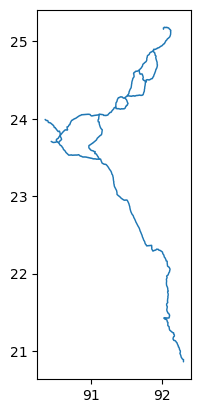

In [16]:
intersecting_N2.plot()

In [17]:
pd.concat([intersections_N1,intersections_N2]).to_csv(main_folder_path + "\\data\\intersections_BONUS.csv")


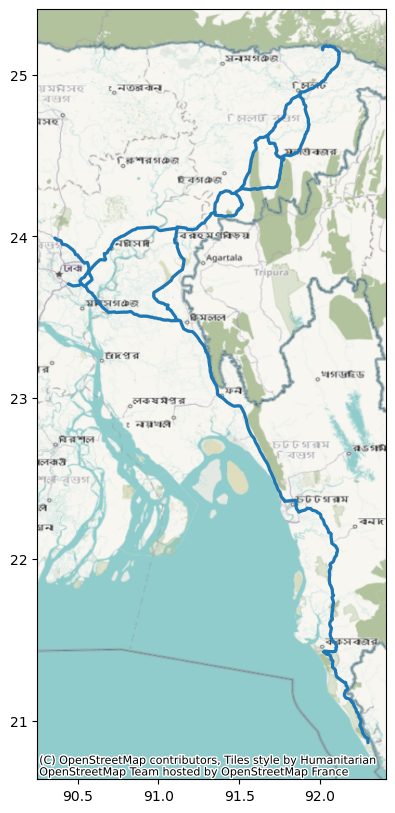

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
# Process intersection data for gdf_N1
intersections_N1.plot(ax=ax)
intersections_N2.plot(ax=ax)
intersecting_N2.plot(ax=ax)
cx.add_basemap(ax=ax,crs="EPSG:4326")

In [19]:
def process_intersection_data(gdf_data, intersect_data):
    df_list = []
    index_list = []
    closest_points = []
    empty_dataframe = gpd.GeoDataFrame(columns=list(gdf.columns)+["intersec_to"],crs="EPSG:4326")

    for intersect_index_N1 in intersect_data.index:
        intersect_point_N1 = intersect_data[intersect_index_N1]
        min_dist = 10000

        for N1_index in gdf_data.index:
            N1_point = gdf_data.loc[N1_index, "geometry"]
            dist = distance(N1_point, intersect_point_N1)

            if dist < min_dist:
                min_dist = dist
                closest_point = N1_index
        series = gdf_data.loc[closest_point]
        series["intersec_to"]=intersect_index_N1    
        empty_dataframe.loc[closest_point]=series


        index_list.append(intersect_index_N1)
        closest_points.append(closest_point)
    
    
    empty_dataframe["type"] = "intersection"
    
    return empty_dataframe

# Process intersection data for gdf_N1
df_intersections_main_N1 = process_intersection_data(gdf_N1, intersections_N1)

# Process intersection data for gdf_N2
df_intersections_main_N2 = process_intersection_data(gdf_N2, intersections_N2)
df_intersections_main =pd.concat([df_intersections_main_N1,df_intersections_main_N2], axis=0, ignore_index=True)
df_intersections_main.to_csv(main_folder_path+"\\data\\intersections_main.csv")

In [20]:
Side_to_N1 = gpd.GeoDataFrame(columns=list(gdf.columns)+["intersec_to"],crs="EPSG:4326")
for road_name in intersections_N1.index:
    road_gdf = gdf[gdf["road"]==road_name]
    intersect_point_N1 =intersections_N1[road_name]
    min_dist=10000
    for road_point_index in road_gdf.index:
        road_point =road_gdf.loc[road_point_index,"geometry"]
        dist =distance(intersect_point_N1,road_point)
        if  dist< min_dist:
            min_dist = dist
            closest_point =road_point_index
    series = road_gdf.loc[closest_point]
    series["intersec_to"]="N1"   
    Side_to_N1.loc[closest_point]=series


Side_to_N2 = gpd.GeoDataFrame(columns=list(gdf.columns)+["intersec_to"],crs="EPSG:4326")
for road_name in intersections_N2.index:
    road_gdf = gdf[gdf["road"]==road_name]
    intersect_point_N2 =intersections_N2[road_name]
    min_dist=10000
    for road_point_index in road_gdf.index:
        road_point =road_gdf.loc[road_point_index,"geometry"]
        dist =distance(intersect_point_N2,road_point)
        if  dist< min_dist:
            min_dist = dist
            closest_point =road_point_index
    series = road_gdf.loc[closest_point]
    series["intersec_to"]="N2"   
    Side_to_N2.loc[closest_point]=series
 

df_intersections_side = pd.concat([Side_to_N1,Side_to_N2], axis=0, ignore_index=True)
df_intersections_side["type"]= "intersection"

df_intersections_side

,road,chainage,lrp,lat,lon,gap,type,name,geometry,intersec_to
0,N102,0.0,LRPS,23.478972,91.118194,NaN,intersection,Start of road from N1 Mainamati,POINT (91.11819 23.47897),N1
1,N104,0.445,LRPSa,23.009278,91.39525,NaN,intersection,Box culvert,POINT (91.39525 23.00928),N1
2,N105,0.0,LRPS,23.690416,90.546611,NaN,intersection,"Starts of road from N1,Dhaka teknaf road at Ma...",POINT (90.54661 23.69042),N1
3,N2,0.0,LRPS,23.705917,90.521444,NaN,intersection,Road Start from N1 at Katchpur,POINT (90.52144 23.70592),N1
4,N8,0.0,LRPS,23.702139,90.435361,NaN,intersection,"Start of road Infront of Padma CNG Station ,Dh...",POINT (90.43536 23.70214),N1
5,N1,8.0,LRP008,23.702056,90.515722,NaN,intersection,Km post missing,POINT (90.51572 23.70206),N2
6,N102,81.714,LRP082,24.042111,91.113972,NaN,intersection,Madhebpur 23 km Sylhet170 km,POINT (91.11397 24.04211),N2
7,N105,12.257,LRP012,23.780555,90.570055,NaN,intersection,"Bangabondhu Bridge 118 km, Mymenshingh 151 km,...",POINT (90.57005 23.78055),N2
8,N204,0.0,LRPS,24.147916,91.346611,NaN,intersection,Road start from N2 at Jagannathganj.,POINT (91.34661 24.14792),N2
9,N207,0.0,LRPS,24.294861,91.51025,NaN,intersection,Road start from N2 at Mirpur.,POINT (91.51025 24.29486),N2


<GeometryArray>
[<LINESTRING (90.443 23.706, 90.45 23.703, 90.45 23.703, 90.452 23.702, 90.46...>,
 <LINESTRING (91.118 23.479, 91.117 23.482, 91.113 23.487, 91.113 23.487, 91....>,
 <LINESTRING (91.399 23.01, 91.395 23.009, 91.39 23.009, 91.381 23.01, 91.38 ...>,
 <LINESTRING (90.547 23.69, 90.551 23.698, 90.552 23.699, 90.558 23.706, 90.5...>,
 <LINESTRING (90.521 23.706, 90.52 23.707, 90.517 23.715, 90.516 23.718, 90.5...>,
 <LINESTRING (91.347 24.148, 91.351 24.148, 91.351 24.148, 91.351 24.146, 91....>,
 <LINESTRING (91.51 24.295, 91.512 24.296, 91.514 24.298, 91.514 24.298, 91.5...>,
 <LINESTRING (91.766 24.471, 91.773 24.476, 91.776 24.476, 91.776 24.476, 91....>,
 <LINESTRING (90.435 23.702, 90.434 23.694, 90.434 23.693, 90.432 23.692, 90....>]
Length: 9, dtype: geometry

<bound method Series.reset_index of N1      LINESTRING (90.44333 23.70603, 90.45042 23.702...
N102    LINESTRING (91.11819 23.47897, 91.11678 23.481...
N104    LINESTRING (91.39942 23.00967, 91.39525 23.009...
N105    LINESTRING (90.54661 23.69042, 90.55106 23.698...
N2      LINESTRING (90.52144 23.70592, 90.52047 23.706...
N204    LINESTRING (91.34661 24.14792, 91.35139 24.148...
N207    LINESTRING (91.51025 24.29486, 91.51208 24.296...
N208    LINESTRING (91.76556 24.47136, 91.77278 24.475...
N8      LINESTRING (90.43536 23.70214, 90.43442 23.693...
dtype: geometry>

In [60]:
df_roads_plot

,index,0
0,N1,"LINESTRING (90.44333 23.70603, 90.45042 23.702..."
1,N102,"LINESTRING (91.11819 23.47897, 91.11678 23.481..."
2,N104,"LINESTRING (91.39942 23.00967, 91.39525 23.009..."
3,N105,"LINESTRING (90.54661 23.69042, 90.55106 23.698..."
4,N2,"LINESTRING (90.52144 23.70592, 90.52047 23.706..."
5,N204,"LINESTRING (91.34661 24.14792, 91.35139 24.148..."
6,N207,"LINESTRING (91.51025 24.29486, 91.51208 24.296..."
7,N208,"LINESTRING (91.76556 24.47136, 91.77278 24.475..."
8,N8,"LINESTRING (90.43536 23.70214, 90.43442 23.693..."


In [62]:
intersections_N1

N102    POLYGON ((91.09869 23.48758, 91.10294 23.48784...
N104    POLYGON ((91.38751 23.01745, 91.39786 23.01003...
N105    POLYGON ((90.54338 23.70256, 90.54516 23.70148...
N2      POLYGON ((90.50979 23.71013, 90.51236 23.71221...
N8      POLYGON ((90.43931 23.69687, 90.43760 23.69783...
dtype: geometry

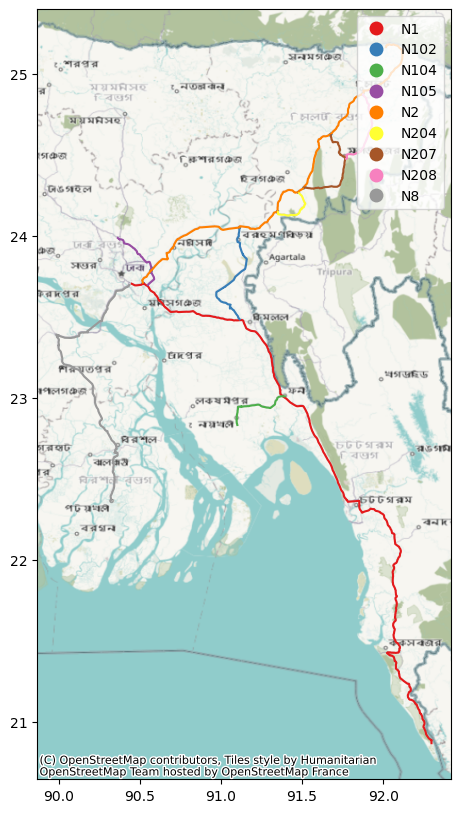

In [64]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
# Process intersection data for gdf_N1
# df_intersections_main.plot(ax=ax)

roads_plot = gseries_test[gseries_test.index.isin(df_intersections_main["intersec_to"])]
df_roads_plot =gseries_test[gseries_test.index.isin(df_intersections_main["intersec_to"])].reset_index()
df_roads_plot.plot(ax=ax,cmap="Set1",column="index",legend=True)
intersections_N2.plot(ax=ax)
# df_intersections_side.plot(ax=ax,color="red")
cx.add_basemap(ax=ax,crs="EPSG:4326")
ax.title.set_text("Roads intersecting with N1 and N2")
# Process intersection data for gdf_N2
# df_intersections_main_N2.plot(ax=ax)

yes


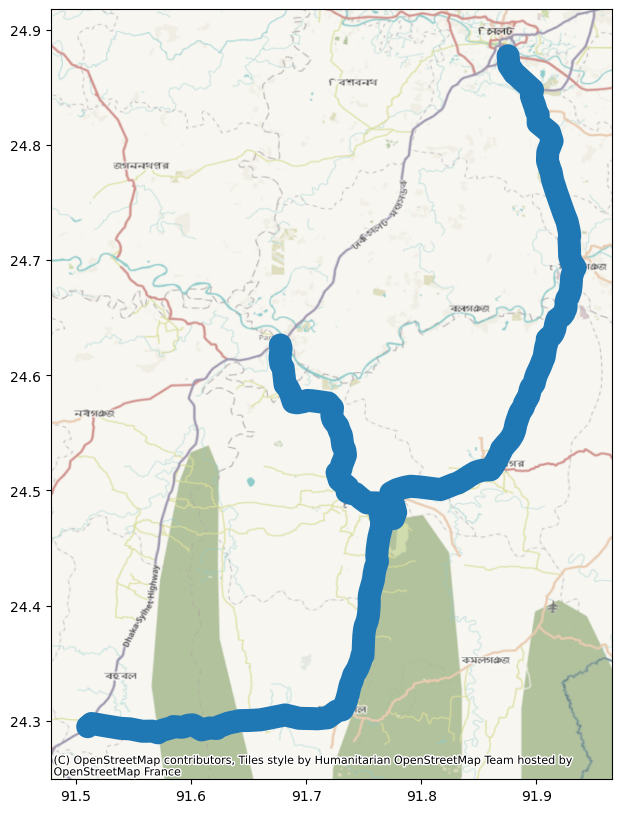

In [22]:
side_roads = gseries[gseries.index.isin(df_intersections_main["intersec_to"])].drop(["N1","N2"])
combinations = list(itertools.combinations(side_roads.index, 2))

#
for combiantion in combinations:
    road_1 = side_roads.loc[combiantion[0]]
    road_2 = side_roads.loc[combiantion[1]]
    if road_1.intersects(road_2):
        print("yes")
        fig,ax = plt.subplots(1,1,figsize=(10,10))
        gpd.GeoSeries(road_1,crs="4326").plot(ax=ax)
        gpd.GeoSeries(road_2,crs="4326").plot(ax=ax)
        cx.add_basemap(ax=ax,crs="EPSG:4326")
        pair = combiantion

In [23]:
gdf_N208 = gdf[gdf["road"]=="N208"]
gdf_N207 = gdf[gdf["road"] == "N207"]

In [24]:
gdf_N208_closest_point = gdf_N208.loc[3512]
gdf_N208_closest_point["intersec_to"]="N207"

1


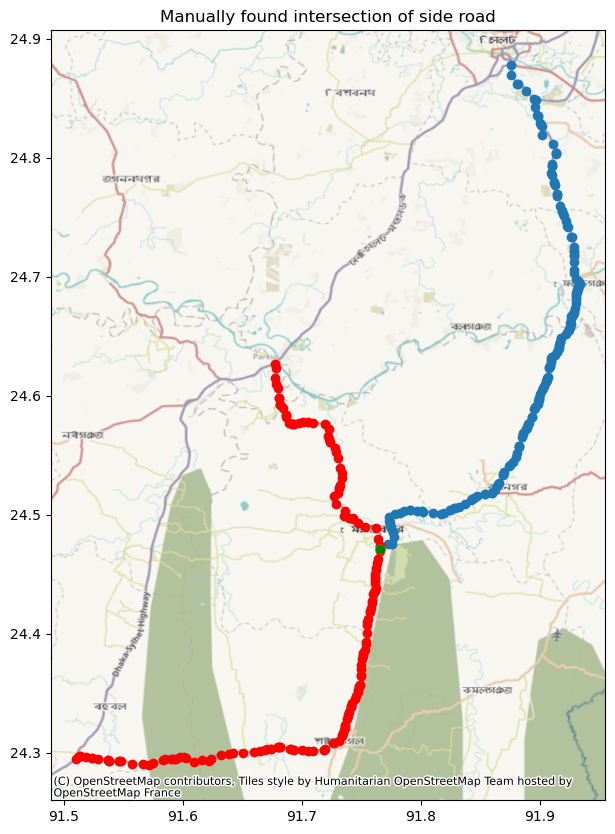

In [25]:
print(1)
min_dist = 10000

for N1_index in gdf_N207.index:
    N1_point = gdf_N207.loc[N1_index, "geometry"]
    dist = distance(N1_point, gdf_N208_closest_point.loc["geometry"])

    if dist < min_dist:
        min_dist = dist
        closest_point = N1_index

gdf_N207_closest_point= gdf_N207.loc[closest_point]
gdf_N207_closest_point["intersec_to"]="N208"

fig,ax = plt.subplots(1,1,figsize=(10,10))
gdf_N208.plot(ax=ax)
gdf_N207.plot(ax=ax,color="red")
gpd.GeoSeries(gdf_N208_closest_point.loc["geometry"],crs="EPSG:4326").plot(ax=ax,color="yellow")
gpd.GeoSeries(gdf_N207_closest_point.loc["geometry"],crs="EPSG:4326").plot(ax=ax,color="green")
ax.title.set_text("Manually found intersection of side road")
cx.add_basemap(ax=ax,crs="EPSG:4326")


In [26]:
df_intersections_all =pd.concat([df_intersections_main,
                                 df_intersections_side,
                                 gpd.GeoDataFrame(gdf_N207_closest_point).T,
                                 gpd.GeoDataFrame(gdf_N208_closest_point).T],axis=0, ignore_index=True)

main_folder_path =os.path.normpath(os.getcwd() + os.sep + os.pardir)
df_intersections_all.to_csv(main_folder_path+"\\data\\intersections.csv")

In [27]:
path = os.getcwd()
parent = os.path.dirname(path)

In [28]:
1

1

In [29]:
df_intersections_all.to_csv(parent+"\\data\\intersections.csv")